In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
import numpy as np
import sklearn.datasets as datasets
import hess.utils as utils

In [2]:
torch.random.manual_seed(88)

In [3]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [4]:
X, Y = twospirals(500, noise=1.3)

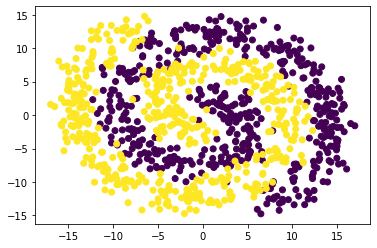

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [6]:
train_x = torch.FloatTensor(X)

In [7]:
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [8]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [9]:
in_dim = 2
out_dim = 1
model = hess.nets.SimpleNet(in_dim, out_dim, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [10]:
buffer = 0.3
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [11]:
print(sum(p.numel() for p in model.parameters()))

2181


In [12]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [13]:
if use_cuda:
    model = model.cuda()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_func = torch.nn.BCEWithLogitsLoss()

losses = []

for step in range(4000):
    optimizer.zero_grad()
    outputs = model(train_x)

    loss=loss_func(outputs, train_y)
    if step % 20 == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()
    
#     ## compute test loss ##
#     outputs = model(test_x)
#     testL = loss_func(outputs,test_y).item()
#     test_losses.append(testL)
#     print("test loss = ", testL)


0.6898990869522095
0.5786029696464539
0.4811790883541107
0.31916311383247375
0.13620053231716156
0.10930381715297699
0.10265635699033737
0.1046542152762413
0.08843578398227692
0.09181457757949829
0.08535201102495193
0.08543558418750763
0.09202766418457031
0.08094459027051926
0.07719678431749344
0.08653080463409424
0.0768967941403389
0.07160986214876175
0.09241329878568649
0.0737822949886322
0.06885672360658646
0.1261078417301178
0.08957876265048981
0.07002139836549759
0.06654138118028641
0.13710783421993256
0.08969824761152267
0.07653338462114334
0.07282412797212601
0.07028527557849884
0.06839217245578766
0.06681642681360245
0.06540390849113464
0.06396875530481339
0.06250283122062683
0.07470691204071045
0.06640899926424026
0.06216242536902428
0.08090250939130783
0.06291493028402328
0.059648025780916214
0.05834079906344414
0.06423366069793701
0.059526652097702026
0.05729087069630623
0.08097700774669647
0.062413062900304794
0.0560593344271183
0.06779570877552032
0.05680792033672333
0.055

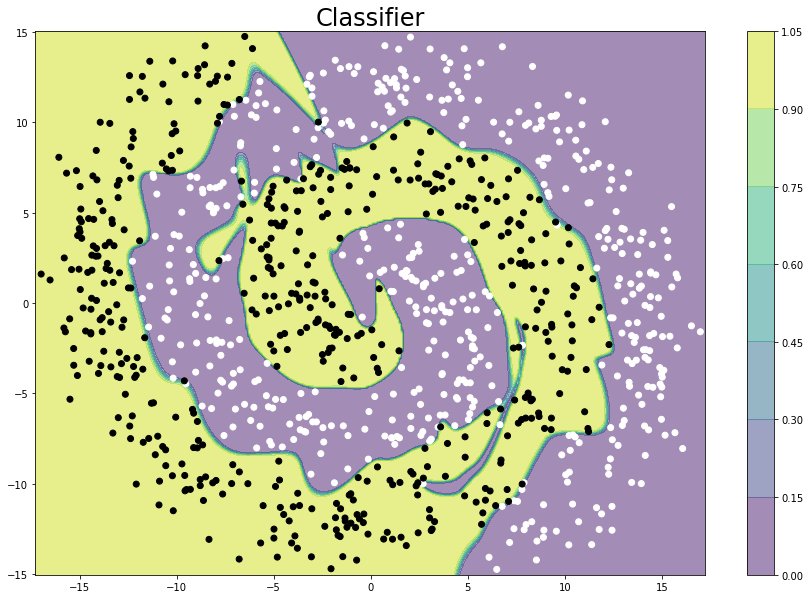

In [15]:
pred = torch.sigmoid(model(in_grid)).detach().reshape(xx.shape)
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, pred, alpha=0.5)
# plt.title("Temp Scaled", fontsize=24)
plt.title("Classifier", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)
# plt.savefig("./two-spiral-classifier.pdf", bbox_inches="tight")

## Let's get this bread

In [16]:
import hess.utils as utils

In [17]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [18]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model,
                            criterion=torch.nn.BCEWithLogitsLoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

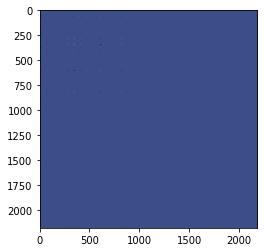

In [19]:
plt.imshow(hessian)

In [20]:
e_val, e_vec = np.linalg.eig(hessian.cpu())
idx = np.abs(e_val).argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

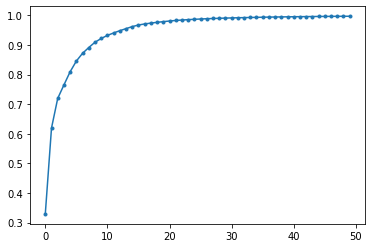

In [21]:
ne = e_val.div(torch.sum(e_val))
plt.plot(np.cumsum(ne[:50].cpu()), marker=".")

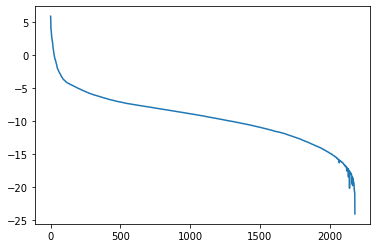

In [22]:
plt.plot(np.log(np.abs(e_val)))

## Save model to use on laptop

In [23]:
# torch.save(optimus.net.state_dict(), "../hess/saved-models/spirals.pt")
saved_pars = model.state_dict()

In [24]:
# torch.save(hessian, "../hess/saved-models/spirals_hessian.pt")

## Get Loss Surfaces

In [25]:
range_ = 0.5
scale = 2.
n_pts = 100

In [26]:
model.load_state_dict(saved_pars)

<All keys matched successfully>

In [27]:
basis = e_vec
full_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [28]:
nvec = 3
basis = e_vec[:, :nvec]
high_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [29]:
nvec = 2000
basis = e_vec[:, -nvec:]
low_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [30]:
ymin = torch.min(full_loss_surface).log()
ymax = torch.max(full_loss_surface).log()

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((bottom(np.linspace(1, 0, 128)),
                       top(np.linspace(1, 0, 128))))
# newcolors[:, -1] = np.linspace(0.25, 0.75, 256)
newcmp = ListedColormap(newcolors, name='OrangeBlue')

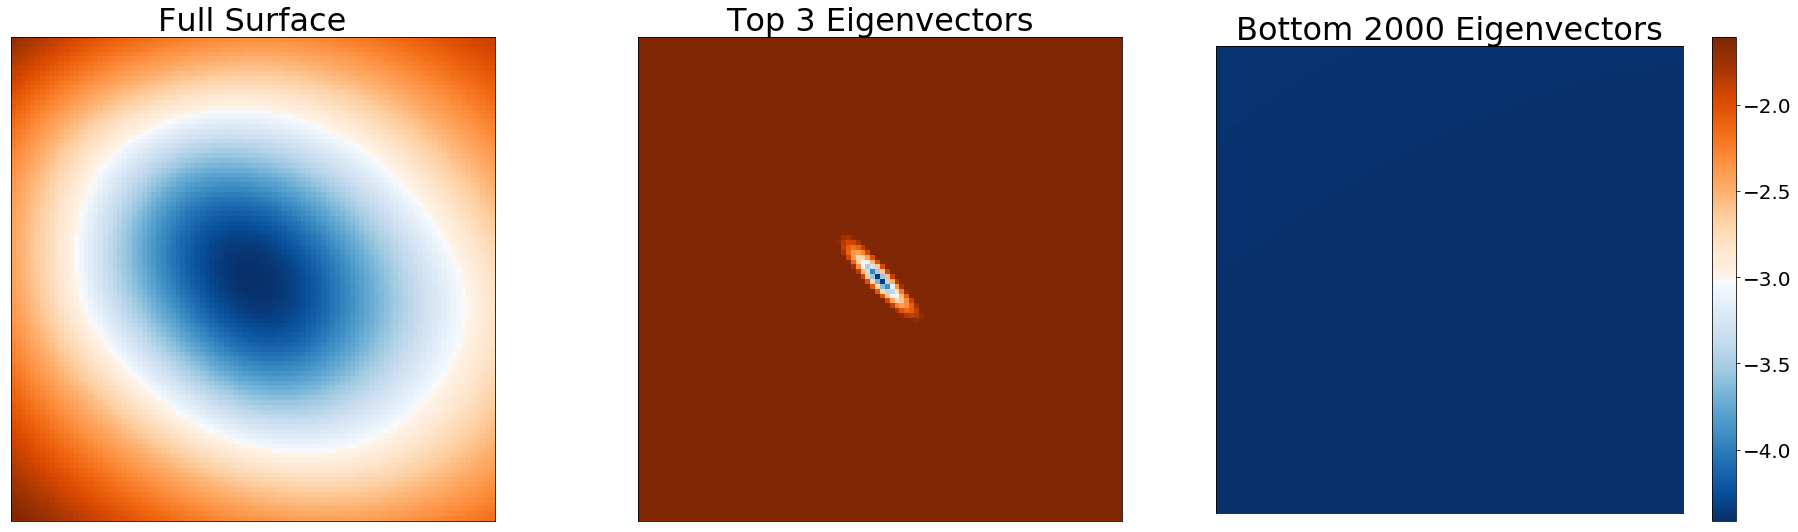

In [31]:
title_fs = 32

fig, ax = plt.subplots(1, 3, figsize=(26, 7.5))
im = ax[0].imshow(full_loss_surface.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# ax[0].autoscale(False)
# cbar=fig.colorbar(im, ax=ax[0])
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Full Surface",
               fontsize=title_fs)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(high_loss_surface.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[1])
# cbar.ax.tick_params(labelsize=20)
# ax[1].autoscale(False)
ax[1].set_title("Top 3 Eigenvectors",
               fontsize=title_fs)
ax[1].set_xticks([])
ax[1].set_yticks([])

im = ax[2].imshow(low_loss_surface.log().detach(), cmap=newcmp, vmin=ymin, vmax=ymax)
cbar=fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[2].set_title("Bottom %i Eigenvectors" % nvec,
               fontsize=title_fs);
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()

plt.savefig("./spiral-loss-surface.pdf", bbox_inches="tight")
plt.show()


In [32]:
range_ = 10.
scale = 5.
n_pts = 75

In [33]:

basis = e_vec
ls1 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [34]:
nvec = 500
basis = e_vec[:, -nvec:]
ls2 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [35]:
basis = e_vec[:, -3:]
ls3 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [36]:
ymin = torch.min(ls1).log()
ymax = torch.max(ls1).log()

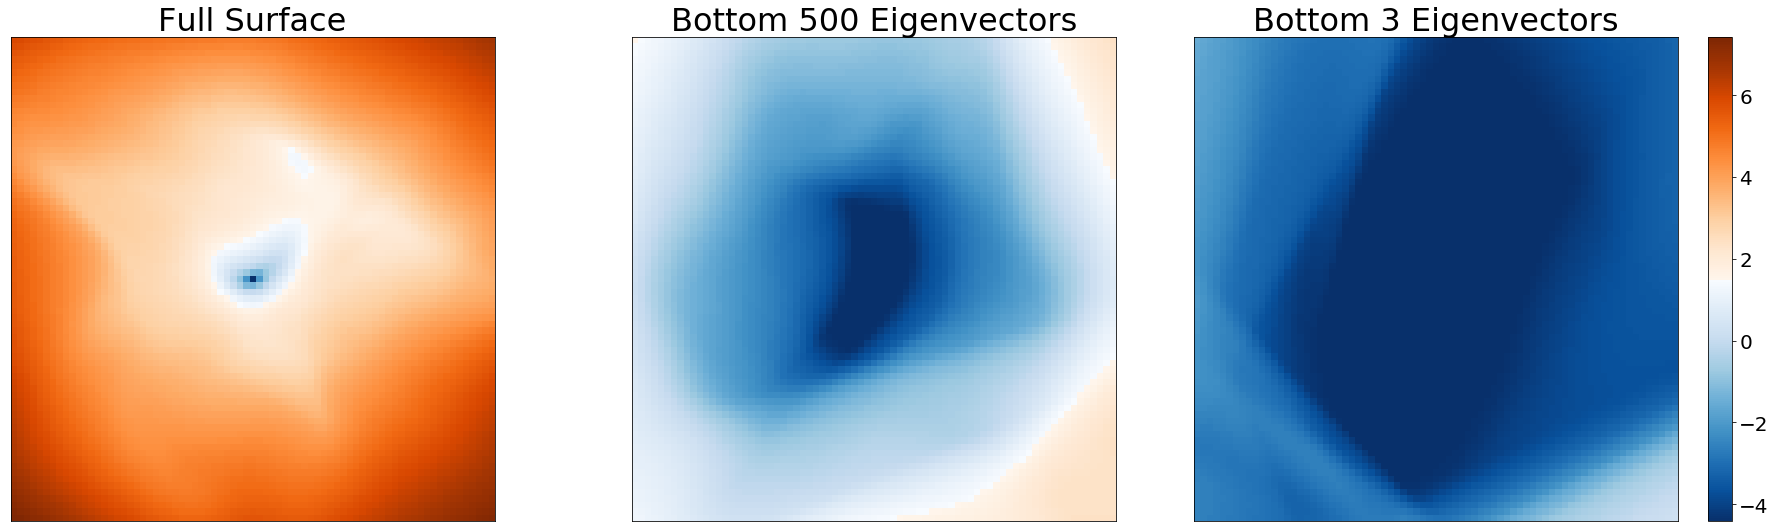

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(26, 7.5))
im = ax[0].imshow(ls1.log().detach(), cmap=newcmp)
# ax[0].autoscale(False)
# cbar=fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Full Surface",
               fontsize=title_fs)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(ls2.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
# ax[1].autoscale(False)
ax[1].set_title("Bottom %i Eigenvectors" % nvec,
               fontsize=title_fs)
ax[1].set_xticks([])
ax[1].set_yticks([])

im = ax[2].imshow(ls3.log().detach(), cmap=newcmp, vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[2])
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[2].set_title("Bottom 3 Eigenvectors",
               fontsize=title_fs);
ax[2].set_xticks([])
ax[2].set_yticks([])
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

# fig.suptitle("Extzended Log-Loss Surfaces", fontsize=34)
plt.savefig("./ext-loss-surface.pdf", bbox_inches="tight")
plt.show()

In [38]:
model.load_state_dict(saved_pars)
pars = utils.flatten([p for p in model.parameters()]) 
par_len = pars.norm()
print(par_len)
print(pars.max())

tensor(16.0857, grad_fn=<NormBackward0>)
tensor(1.6353, grad_fn=<MaxBackward1>)


### Generate Parameter Perturbations in Low-Curvature Directions

In [39]:
buffer = 0.4
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [40]:
model.load_state_dict(saved_pars)
orig_preds = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)
orig_pt_pred = torch.sigmoid(model(train_x))

In [41]:
n_vec = 500
scale = par_len/2
basis = e_vec[:, -n_vec:]

model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]
    
perturbed_pars = utils.flatten(model.parameters())
    
    
low_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)
low_pt_pred = torch.sigmoid(model(train_x))

In [42]:
print(perturbed_pars.norm())
print(perturbed_pars.max())

tensor(18.0377, grad_fn=<NormBackward0>)
tensor(1.6206, grad_fn=<MaxBackward1>)


In [43]:
n_vec = 3
scale = 0.1
basis = e_vec[:, :n_vec]


model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]

high_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)
high_pt_pred = torch.sigmoid(model(train_x))

In [44]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
alphacolors = np.copy(newcolors)
alphacolors[:, -1] = np.linspace(0.25, 0.75, 256)

newcmp = ListedColormap(newcolors, name='OrangeBlue')
alphacmp = ListedColormap(alphacolors, name='OrangeBlue')

In [45]:
import seaborn as sns
import pandas as pd

dat = pd.DataFrame({'x1': train_x[:, 0], 'x2': train_x[:, 1], "y":train_y[:, 0]})

[Text(0, 0.5, ''), Text(0.5, 0, '')]

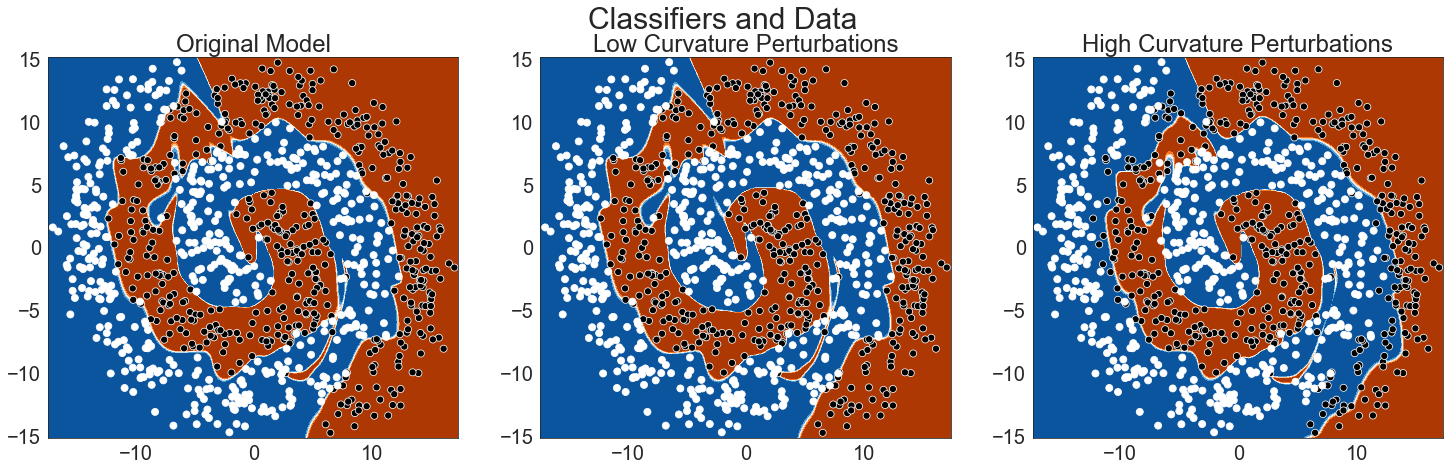

In [46]:
sup_fs = 30
title_fs = 24
ax_fs = 20
colors = newcmp


sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

fig.suptitle('Classifiers and Data', fontsize=sup_fs)


ax1.contourf(xx, yy, orig_preds.detach(), cmap=colors)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax1,
               palette=['black', 'white'], s=50, legend=False)
ax1.set_title("Original Model", fontsize=title_fs)
ax1.tick_params(axis="both", labelsize=ax_fs)
ax1.set(xlabel='', ylabel='')

ax2.contourf(xx, yy, low_pred.detach(), cmap=colors)
# ax2.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#            s=3)
ax2.set_title("Low Curvature Perturbations", fontsize=title_fs)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax2,
               palette=['black', 'white'], s=50, legend=False)
ax2.tick_params(axis="both", labelsize=ax_fs)
ax2.set(xlabel='', ylabel='')

ax3.contourf(xx, yy, high_pred.detach(), cmap=colors)
# ax3.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#         s=3)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax3,
               palette=['black', 'white'], s=50, legend=False)
ax3.set_title("High Curvature Perturbations", fontsize=title_fs)
ax3.tick_params(axis="both", labelsize=ax_fs)
ax3.set(xlabel='', ylabel='')

# plt.savefig("./perturbed-classifiers.pdf", bbox_inches='tight')

In [47]:
low_diff = orig_preds - low_pred
high_diff = orig_preds - high_pred

ymin = torch.min(torch.cat((low_diff, high_diff))).item()
ymax = torch.max(torch.cat((low_diff, high_diff))).item()

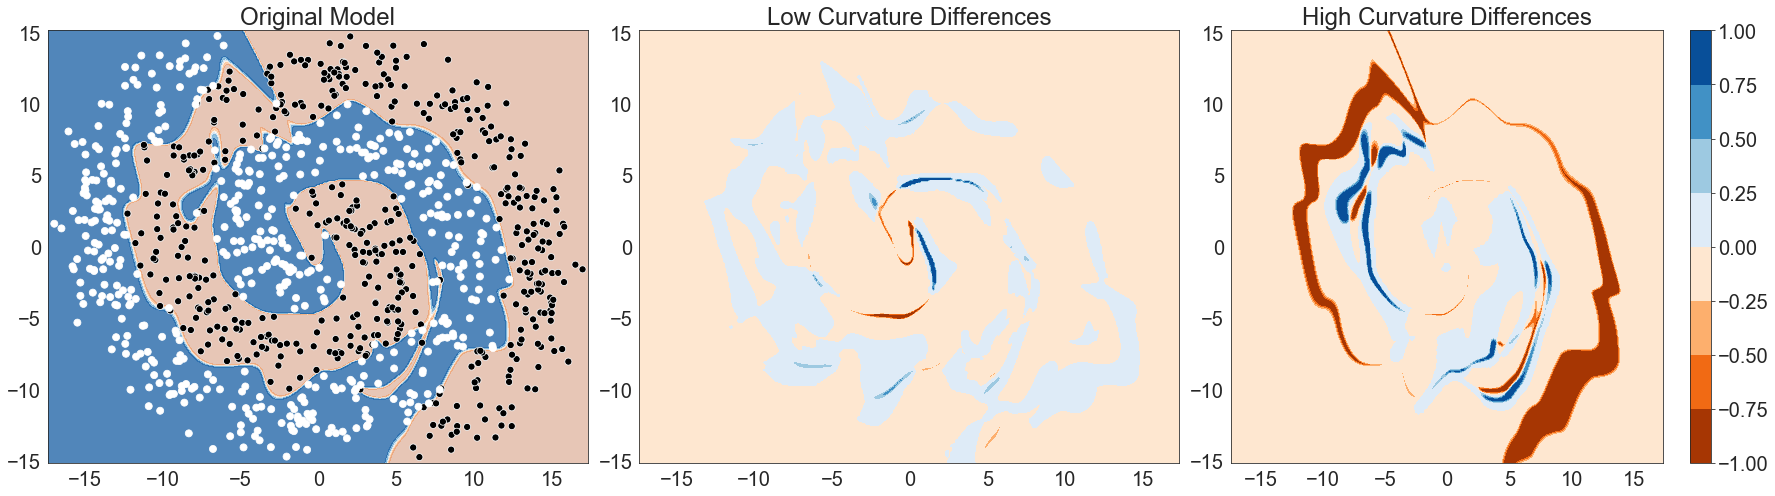

In [48]:
sup_fs = 30
title_fs = 24
ax_fs = 20
colors = newcmp


sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

# fig.suptitle('Classifiers and Data', fontsize=sup_fs)


ax1.contourf(xx, yy, orig_preds.detach(), cmap=alphacmp)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax1,
               palette=['black', 'white'], s=50, legend=False)
ax1.set_title("Original Model", fontsize=title_fs)
ax1.tick_params(axis="both", labelsize=ax_fs)
ax1.set(xlabel='', ylabel='')

ax2.contourf(xx, yy, low_diff.detach(), cmap=colors,
            vmin=ymin, vmax=ymax)
# ax2.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#            s=3)
ax2.set_title("Low Curvature Differences", fontsize=title_fs)
# sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax2,
#                palette=['black', 'white'], s=50, legend=False)
ax2.tick_params(axis="both", labelsize=ax_fs)
ax2.set(xlabel='', ylabel='')

im = ax3.contourf(xx, yy, high_diff.detach(), cmap=colors,
            vmin=ymin, vmax=ymax)
# ax3.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#         s=3)
# sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax3,
#                palette=['black', 'white'], s=50, legend=False)
ax3.set_title("High Curvature Differences", fontsize=title_fs)
ax3.tick_params(axis="both", labelsize=ax_fs)
ax3.set(xlabel='', ylabel='')

cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

plt.savefig("./classifier-differences.pdf", bbox_inches='tight')

### Do the Original and Low Curvature Models predict the same?

In [49]:
orig_pt_pred[orig_pt_pred < 0.5] = 0
orig_pt_pred[orig_pt_pred >= 0.5] = 1

low_pt_pred[low_pt_pred < 0.5] = 0
low_pt_pred[low_pt_pred >= 0.5] = 1

In [50]:
print(torch.sum((orig_pt_pred - low_pt_pred).abs()))
print(torch.sum((train_y - low_pt_pred).abs()))

tensor(2., grad_fn=<SumBackward0>)
tensor(3., grad_fn=<SumBackward0>)


In [51]:
orig_pt_pred[orig_pt_pred < 0.5] = 0
orig_pt_pred[orig_pt_pred >= 0.5] = 1

high_pt_pred[high_pt_pred < 0.5] = 0
high_pt_pred[high_pt_pred >= 0.5] = 1

In [52]:
print(torch.sum((orig_pt_pred - high_pt_pred).abs()))
print(torch.sum((train_y - high_pt_pred).abs()))

tensor(110., grad_fn=<SumBackward0>)
tensor(111., grad_fn=<SumBackward0>)


In [53]:
torch.sum((orig_pt_pred - train_y).abs())

tensor(3., grad_fn=<SumBackward0>)

## And Plot some Sample Classifiers

In [77]:
buffer = 1.
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [78]:
n_vec = 1
n_scale = 10
max_scale = 0.5
scales = torch.linspace(0, max_scale, n_scale)
basis = e_vec[:, :n_vec]
high_preds = torch.zeros(n_scale, xx.shape[0], xx.shape[1])

for scl_ind, scl in enumerate(scales):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scl)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]

    high_preds[scl_ind, :, :] = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [79]:
n_vec = 1000
basis = e_vec[:, -n_vec:]
low_preds = torch.zeros(n_scale, xx.shape[0], xx.shape[1])

n_scale = 10
max_scale = 5.
low_scales = torch.linspace(0, max_scale, n_scale)
for scl_ind, scl in enumerate(low_scales):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scl)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]

    low_preds[scl_ind, :, :] = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [80]:
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

subtitle_fs = 26
title_fs = 40

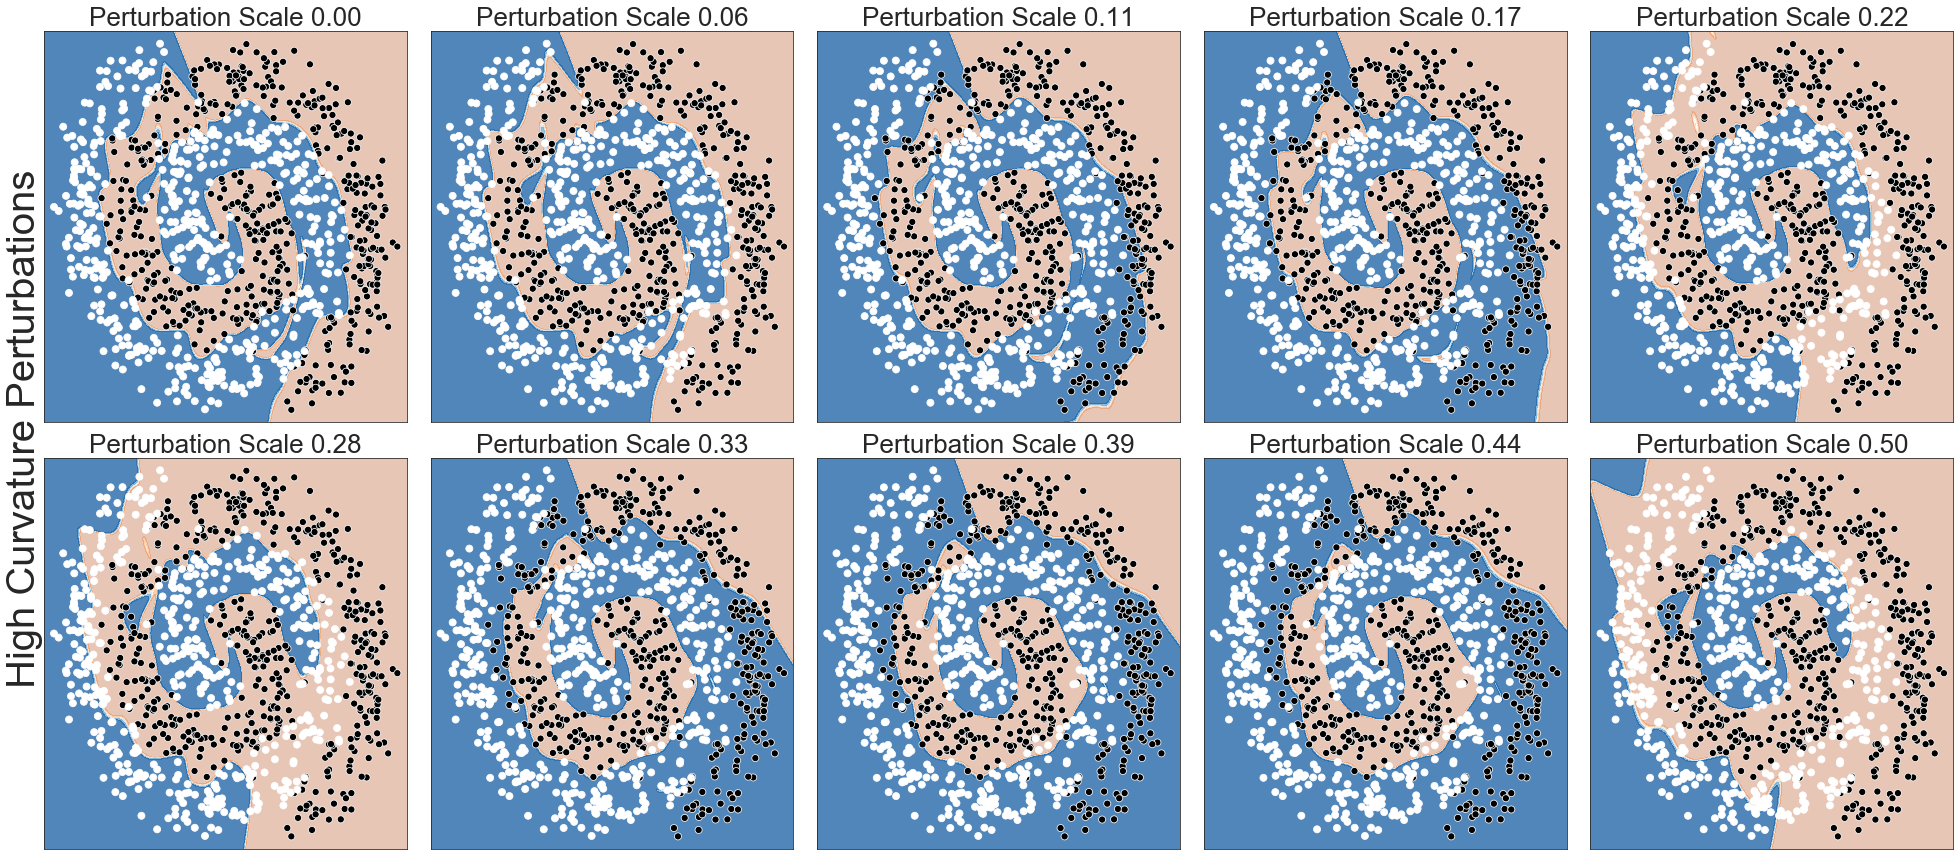

In [83]:
sns.set_style("white")
f, axes = plt.subplots(2, 5, figsize=(27, 12), sharex=True)
for ii in range(2):
    for scl_ind in range(5):
        axes[ii, scl_ind].contourf(xx, yy, high_preds[ii*5 + scl_ind, :, :].detach(),
                                  cmap=alphacmp)
        sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=axes[ii, scl_ind],
                       palette=['black', 'white'], s=50, legend=False)
        axes[ii, scl_ind].set_ylabel("")
        axes[ii, scl_ind].set_xlabel("")
        axes[ii, scl_ind].set_title("Perturbation Scale %.2f"  % scales[ii*5 + scl_ind].item(),
                                   fontsize=subtitle_fs)

plt.setp(axes, yticks=[], xticks=[])
f.text(-0.01, 0.5, 'High Curvature Perturbations', va='center', rotation='vertical',
      fontsize=title_fs)
plt.tight_layout()
plt.savefig("./high_curve_perturbations.pdf", bbox_inches="tight")

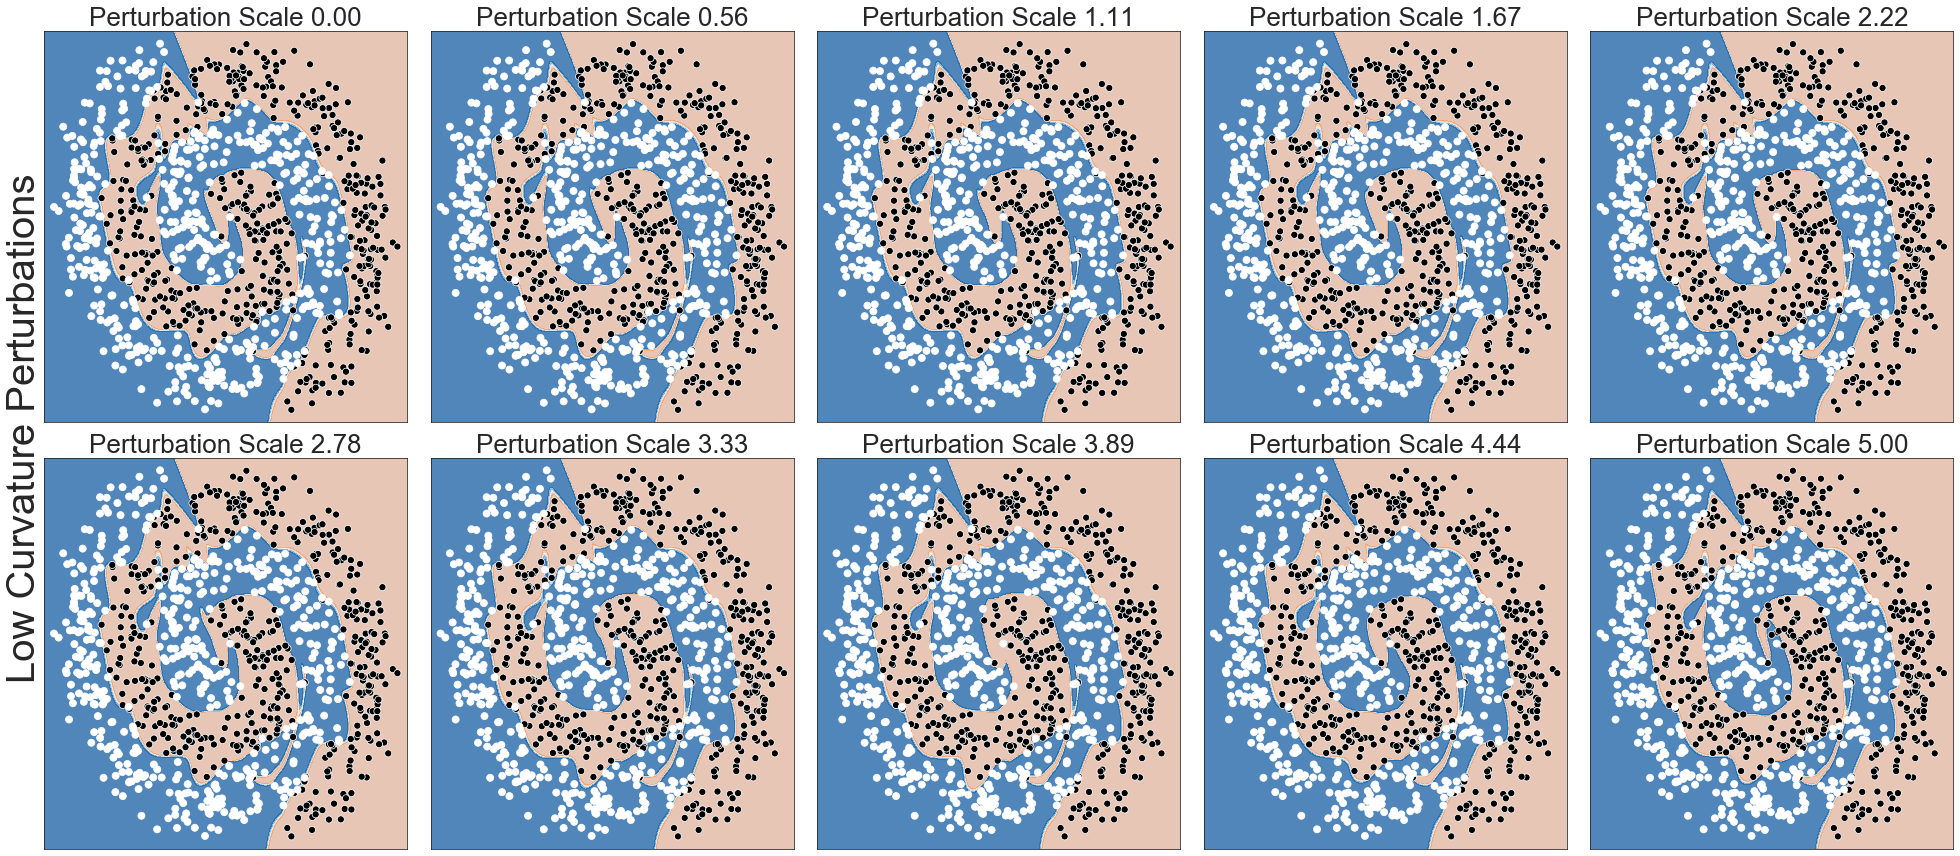

In [84]:
sns.set_style("white")
f, axes = plt.subplots(2, 5, figsize=(27, 12), sharex=True)
for ii in range(2):
    for scl_ind in range(5):
        axes[ii, scl_ind].contourf(xx, yy, low_preds[ii*5 + scl_ind, :, :].detach(),
                                  cmap=alphacmp)
        sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=axes[ii, scl_ind],
                       palette=['black', 'white'], s=50, legend=False)
        axes[ii, scl_ind].set_ylabel("")
        axes[ii, scl_ind].set_xlabel("")
        axes[ii, scl_ind].set_title("Perturbation Scale %.2f"  % low_scales[ii*5 + scl_ind].item(),
                                   fontsize=subtitle_fs)

plt.setp(axes, yticks=[], xticks=[])
f.text(-0.01, 0.5, 'Low Curvature Perturbations', va='center', rotation='vertical',
      fontsize=title_fs)
plt.tight_layout()
plt.savefig("./low_curve_perturbations.pdf", bbox_inches="tight")